* Romain Pous, 2021
* Computes steric height for ARGO datas

This notebook computes steric height at specific points in the ocean for ARGO profilers or moorings. After a quick definition of dynamic and steric height, we describe the library used in this code. In addition to a code to obtain the steric height and a code to plot it, we made an usable ARGO profiler model to test it. The model has temperature, salinity, depth and date datas plausible for ARGO profilers.


## 1) Introduction

### a) Steric Height

Steric height is the contribution of density to the sea level in meter. Total sea level is obtained with steric height and massic height which is estimated by gravimetric balance.

Steric height can be explicited as (Storto 2017, https://doi.org/10.1007/s00382-015-2554-9) :

$$ \Delta H = - \int_{-H}^0 \frac{\Delta\rho}{\rho 0} dz $$


Steric height anomaly $ \Delta H $ is in meters, $\Delta\rho$ is the  density variation and $\rho 0$ counts for atmosphere.

### b) Dynamic height

Dynamic height anomaly is the geostrophic streamfunction for the difference between the horizontal velocity at the pressure concerned, p, and the horizontal velocity at p_ref. Dynamic height anomaly is the geostrophic streamfunction in an isobaric surface. The reference values used for the specific volume anomaly are SSO = 35.16504 g/kg and CT = 0 deg C.  This function calculates specific volume anomaly using the computationally efficient 75-term expression for specific volume (Roquet et al., 2015).

gsw_geo_strf_dyn_height,  evaluates  the  pressure  integral  of specific  volume  using  Absolute Salinity and Absolute Temperature “interpolated”  with  respect  to  pressure  using  a  time‐tested scheme of the method of Reiniger and Ross (1968). Dynamic height is expressed in (m^2/s^2).

Dynamic height and steric height are linked by gravitational constant. 

## 2) Preparation

### a) Library

We use functions from gsw (Global sea water) library from TEOS-10 and from sw library.
From gsw, we use :

-gsw.SA_from_SP to compute Absolute Salinity

-gsw.CT_from_t  to compute Absolute Temperature

-gsw.geo_strf_dyn_height to compute Dynamical Height

We also need Pressure that we have with sw.eos80.pres from sw library.

### b) Import

In [1]:
#To deal with data
import xarray as xr
import gsw
import seawater as sw
import os

#For basic calculus
import numpy as np
import numpy.ma as ma

#For the plots
import matplotlib.pyplot as plt
import pylab as plot

params = {'legend.fontsize': 20,
          'legend.handlelength': 2,
          'axes.titlesize' : 24,
          'axes.labelsize' : 20,
          'lines.linewidth' : 3,
          'lines.markersize' : 10,
          'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}

plot.rcParams.update(params)

#To deal with exemple
import random

### c) To deal with corrupted datas

We can't use masked array with our functions as we usually do for Argo Real-Time Datas. There are compatibility issues. Instead, we make a verification function. For each profile that we have, we determine if there is a fill value (99999.0). Our verification function gives us an array of level where datas are not filled with fill value.

In [2]:
def verification(ds,i):
        """Verification function. It identifies uncorrupted levels.
        - ds is the opened file where your ARGO data set is
        - L is the number of levels for a profile. It's often written as len(ds.DEPTH)
        - i is the i-th cycle of the profiler 
        - ind is an array of uncorrupted levels for one profile"""
        ind=[]
        ind=np.where(ds.PSAL_OBS[i]!=99999.0)
        return ind

## 3) Steric height function

In this function, we calculate steric height by steric height for each profile. 

To compute steric height we need to :

-Compute pressure with depth and latitude

-Compute absolute salinity with observed salinity, pressure, longitude and latitude

-Compute absolute temperature with absolute salinity, observed temperature and pressure

-Compute dynamic height with pressure, absolute salinity,absolute temperature and a pressure reference

Then we divide dynamic height with gravity constante and we get steric height.

It returns us a numpy array "H[0]" with a l size. l is the number of cycle for our profiler so it depends of your data file. Each index counts as  the steric height for your profiler for his position in the seas.


To understand how this code is written, we need to address one point : How are the raw ARGO data organized? First of all, there are 150 depths for a profile. In fact, the ARGO floats do not go all the way to 2000m and the deepest levels are not reached. The unacquired data are then filled with the value 99999. We usually use functions that hide this value. However, hidden arrays cannot be taken as arguments in our functions.  We have to determine which levels are usable upstream. The identification function is used for this. However, the same float will not have the same number of levels observed at each of these cycles which poses problems of dimensions. Furthermore in gsw.geo_strf_dyn_height, pressure needs to increase for each step to be used. To solve those problems practically, we fill each column of steric height calculated by 0. We finally obtain the same dimension for each cycle (or each time step).


In [1]:
def Steric_height(ds):
    """Steric height function that computes it for a profiler over time. 
    - ds is the opened file where your ARGO data set is
    - H[0] is an array of steric height in meter filled with steric height for each time step"""
    #Number of ARGO cycle
    l=len(ds.JULD)
    #Number of ARGO levels for a profiler.
    L=len(ds.DEPTH[0])
    #Gravitational constant 
    g=9.81
    #Pressure reference
    pref=1400
    #H is our steric height matrix
    H=[]

    #Initialisation : we need this step to create our H matrix
    IND=verification(ds,0)
    Length=len(IND[0])
    C_Ps=np.zeros(Length)
    C_SA=np.zeros(Length)
    C_CT=np.zeros(Length)
    C_H=np.zeros(L)

    for j in range (Length):
        #Conversion depth in sea pressure
        C_Ps[j]=sw.eos80.pres(ds.DEPTH[0][IND[0][j]],ds.LATITUDE[0])
        #Conversion practical salinity in absolute salinity
        C_SA[j]=gsw.SA_from_SP(ds.PSAL_OBS[0][IND[0][j]], C_Ps[j], ds.LONGITUDE[0], ds.LATITUDE[0])
        #Conversion in situ temperature in absolute temperature
        C_CT[j]=gsw.CT_from_t(C_SA[j], ds.POTM_OBS[0][IND[0][j]], C_Ps[j])
    C_H=gsw.geo_strf_dyn_height(C_SA,C_CT,C_Ps,pref)/g  
    while len(C_H)<L:
        C_H=np.append(C_H,0)
    H=C_H

    #Steric height loop
    for i in range(l-1):
        IND=verification(ds,i+1)
        Length=len(IND[0])
        C_Ps=np.zeros(Length)
        C_SA=np.zeros(Length)
        C_CT=np.zeros(Length)
        C_H=np.zeros(L)
        for j in range (Length):
            #Conversion depth in sea pressure
            C_Ps[j]=sw.eos80.pres(ds.DEPTH[i][IND[0][j]],ds.LATITUDE[i])
            #Conversion practical salinity in absolute salinity
            C_SA[j]=gsw.SA_from_SP(ds.PSAL_OBS[i+1][IND[0][j]], C_Ps[j], ds.LONGITUDE[i+1], ds.LATITUDE[i+1])
            #Conversion in situ temperature in absolute temperature
            C_CT[j]=gsw.CT_from_t(C_SA[j], ds.POTM_OBS[i+1][IND[0][j]], C_Ps[j])
    
        C_H=gsw.geo_strf_dyn_height(C_SA,C_CT,C_Ps,pref)/g
        while len(C_H)<L:
            C_H=np.append(C_H,0)
        H=np.c_[H, C_H]
        
    return H[0]

In [6]:
onefile='/mnt/pousr/old-equipes/IGE/meom/workdir/pousr/ARGO/selec_profiles19007_y2010-2012_r1-50.nc'
ds=xr.open_dataset(onefile,decode_times=False)
H=Steric_height(ds)

In [7]:
H

array([1.52931686, 1.52316458, 1.52795955, 1.51110001, 1.52862376,
       1.52598603, 1.52723556, 1.55736342, 1.57865822, 1.55765183,
       1.5411675 , 1.54782389, 1.55935603, 1.50163198, 1.52093546,
       1.50198286, 1.50708063, 1.5282353 , 1.5675967 , 1.58558459,
       1.59433162, 1.57142655, 1.56877495, 1.56135978, 1.55758178,
       1.57603633, 1.56555992, 1.53862481, 1.51971706, 1.56241215,
       1.56525149, 1.56303557, 1.57150278, 1.55201473, 1.56869195,
       1.56155309, 1.55261591, 1.52239416, 1.50658963, 1.460833  ,
       1.4523566 , 1.46873663, 1.50124311, 1.50884786, 1.49706455,
       1.52039074, 1.50645004, 1.51022999, 1.51996567, 1.55111973,
       1.52410506, 1.54660793, 1.56493715, 1.55402085, 1.52963041,
       1.53492128, 1.56225363, 1.56440268, 1.58230773, 1.52167024,
       1.53200747, 1.56300007, 1.55787074, 1.57201152, 1.58078118,
       1.59941464, 1.59418589, 1.59787375, 1.58729645, 1.59201416,
       1.58026564, 1.57468589, 1.54824667, 1.53498393, 1.50044

## 4) Plot function

Steric_plot will plot steric height over time for your profiler

In [67]:
def Steric_Plot(ds,H):
    
    from matplotlib import cycler
    colors = cycler('color',['#fc280f', '#5fdcff', '#f4ba26', '#85c54c', '#c6d7e0']) # colors for artists will be cycled from this list by default
    plt.rc('figure', facecolor='#FFFFFF') # facecolor is background colour
    plt.rc('axes', facecolor='#FFFFFF', edgecolor='#FFFFFF',
       axisbelow=True, grid=True, prop_cycle=colors) # "axisbelow" set axis ticks and gridlines are below all artists
    plt.rc('grid', color='#222222', linestyle='solid')
    plt.rc('xtick', direction='in', color='#222222')
    plt.rc('ytick', direction='in', color='#222222')
    plt.rc('patch', edgecolor='#e3e3e3')
    plt.rc('lines', linewidth=1.5)


    fig = plt.figure(figsize=(17, 15))  # (w,h)
    ax = plt.subplot() 

    ax.plot((ds.JULD-ds.JULD[0]), H,color='#fd411e',label='Steric height', zorder=1, marker = '+')
       
    plt.suptitle('Steric Height evolution for an ARGO profiler ', size=30, color='#222222')
    ax.set_ylabel('Steric Height [m]',color='#222222')
        
    ax.legend(labelcolor='#222222',fontsize='xx-large') 
    ax.set_xlabel('Time [days]',color='#222222')
    ax.grid(True, which='both')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
   

## 5) Exemple

Here is an example with a profiler reconstructed by a class

In [2]:
class Profiler:
    """Profiler class.
    -self.JULD is an array for date of each cycle,
    -self.PSAL_OBS is a salinity array for each cycle and each depth,
    -self.POTM_OBS is a temperature array for each cycle and each depth,
    -self.DEPTH is an array with depths,
    -self.LATITUDE and self.LONGITUDE"""
    def __init__(self, file = None, **kwargs):
        """init methode for our class Profiler.
        -File can be filled with the path of a file to copy ARGO datas from ARGO dataset.
        Otherwise, Profiler will represent a random profiler.
        -csr can be filled to compute steric height."""

        csr=kwargs.get('csr', None)
        
        if file is not None:
            self.readfile(file)
        else:
            self.create_random_profile()
                
        if csr is not None: 
            self.steric_height = self.compute_steric_height()
        else:
            self.steric_height='Oops, please ask to compute steric height.'
                
    def readfile(self,file):
        """Open and read file for an ARGO profiler.
        -Return an error if file doesn't exist or extract datas from an ARGO dataset."""
        # verifie que le fichier existe   
        filexist=os.path.isfile(file)
        if filexist == False:
            self.print_error('nofile')
        else:
            ds_argo=xr.open_dataset(file,decode_times=False) 
            # on ouvre, on lit le fichier
            self.JULD=ds_argo.JULD
            self.PSAL_OBS=ds_argo.PSAL_OBS
            self.POTM_OBS=ds_argo.POTM_OBS
            self.DEPTH=ds_argo.DEPTH
            self.LATITUDE=ds_argo.LATITUDE
            self.LONGITUDE=ds_argo.LONGITUDE
            
    def create_random_profile(self):
        """ Create a random profile to compute and test steric height function."""
        n_cycle=100
        n_level=150
        self.JULD=np.ones(n_cycle)
        self.PSAL_OBS=99999.0*np.ones((n_cycle,n_level))
        self.POTM_OBS=99999.0*np.ones((n_cycle,n_level))
        self.DEPTH=99999.0*np.ones((n_cycle,n_level))
        self.LATITUDE=np.ones(n_cycle)
        self.LONGITUDE=np.ones(n_cycle)
        for i in range(n_cycle):
            self.JULD[i]=i*10
            self.LATITUDE[i]=random.uniform(23, 26)
            self.LONGITUDE[i]=random.uniform(-33, -27)
            for j in range(n_level-50):
                self.PSAL_OBS[i][j]=random.uniform(35.5, 36)
                self.POTM_OBS[i][j]=random.uniform(5, 7)+random.uniform(-0.01, +0.05)
                self.DEPTH[i][j]=j*200+random.uniform(-2,2)
    
    
    def compute_steric_height(self):
        """Compite steric height for a profiler over time. 
        - ds is the opened file that contains ARGO data set,
        - H[0] is an array of steric height in meter filled with steric height for each time step."""
        #Number of ARGO cycle
        n_cycle=len(self.JULD)
        #Number of ARGO levels for a profiler.
        n_level=len(self.DEPTH[0])
        #Gravitational constant 
        g=9.81
        #Pressure reference
        pref=1400
        #H is our steric height matrix
        H=[]

        #Initialisation : we need this step to create our H matrix
        IND=verification(self,0)
        Length=len(IND[0])
        C_Ps=np.zeros(Length)
        C_SA=np.zeros(Length)
        C_CT=np.zeros(Length)
        C_H=np.zeros(n_level)

        for j in range (Length):
            #Conversion depth in sea pressure
            C_Ps[j]=sw.eos80.pres(self.DEPTH[0][IND[0][j]],self.LATITUDE[0])
            #Conversion practical salinity in absolute salinity
            C_SA[j]=gsw.SA_from_SP(self.PSAL_OBS[0][IND[0][j]], C_Ps[j], self.LONGITUDE[0], self.LATITUDE[0])
            #Conversion in situ temperature in absolute temperature
            C_CT[j]=gsw.CT_from_t(C_SA[j], self.POTM_OBS[0][IND[0][j]], C_Ps[j])
        C_H=gsw.geo_strf_dyn_height(C_SA,C_CT,C_Ps,pref)/g  
        while len(C_H)<n_level:
            C_H=np.append(C_H,0)
        H=C_H

        #Steric height loop
        for i in range(n_cycle-1):
            IND=verification(self,i+1)
            Length=len(IND[0])
            C_Ps=np.zeros(Length)
            C_SA=np.zeros(Length)
            C_CT=np.zeros(Length)
            C_H=np.zeros(n_level)
            for j in range (Length):
                #Conversion depth in sea pressure
                C_Ps[j]=sw.eos80.pres(self.DEPTH[i][IND[0][j]],self.LATITUDE[i])
                #Conversion practical salinity in absolute salinity
                C_SA[j]=gsw.SA_from_SP(self.PSAL_OBS[i+1][IND[0][j]], C_Ps[j], self.LONGITUDE[i+1], self.LATITUDE[i+1])
                #Conversion in situ temperature in absolute temperature
                C_CT[j]=gsw.CT_from_t(C_SA[j], self.POTM_OBS[i+1][IND[0][j]], C_Ps[j])
    
            C_H=gsw.geo_strf_dyn_height(C_SA,C_CT,C_Ps,pref)/g
            while len(C_H)<n_level:
                C_H=np.append(C_H,0)
            H=np.c_[H, C_H]
        
        return H[0]
    
    def print_error(self, errtype):
        if errtype == 'nofile':
            print('Oops, the file does not exist. Please double check.')
        

In [62]:
onefile='/mnt/pousr/old-equipes/IGE/meom/workdir/pousr/ARGO/selec_profiles19007_y2010-2012_r1-50.nc'
rec={'csr':1}
P=Profiler(file=onefile,**rec)

In [63]:
P.steric_height

array([1.52931686, 1.52316458, 1.52795955, 1.51110001, 1.52862376,
       1.52598603, 1.52723556, 1.55736342, 1.57865822, 1.55765183,
       1.5411675 , 1.54782389, 1.55935603, 1.50163198, 1.52093546,
       1.50198286, 1.50708063, 1.5282353 , 1.5675967 , 1.58558459,
       1.59433162, 1.57142655, 1.56877495, 1.56135978, 1.55758178,
       1.57603633, 1.56555992, 1.53862481, 1.51971706, 1.56241215,
       1.56525149, 1.56303557, 1.57150278, 1.55201473, 1.56869195,
       1.56155309, 1.55261591, 1.52239416, 1.50658963, 1.460833  ,
       1.4523566 , 1.46873663, 1.50124311, 1.50884786, 1.49706455,
       1.52039074, 1.50645004, 1.51022999, 1.51996567, 1.55111973,
       1.52410506, 1.54660793, 1.56493715, 1.55402085, 1.52963041,
       1.53492128, 1.56225363, 1.56440268, 1.58230773, 1.52167024,
       1.53200747, 1.56300007, 1.55787074, 1.57201152, 1.58078118,
       1.59941464, 1.59418589, 1.59787375, 1.58729645, 1.59201416,
       1.58026564, 1.57468589, 1.54824667, 1.53498393, 1.50044

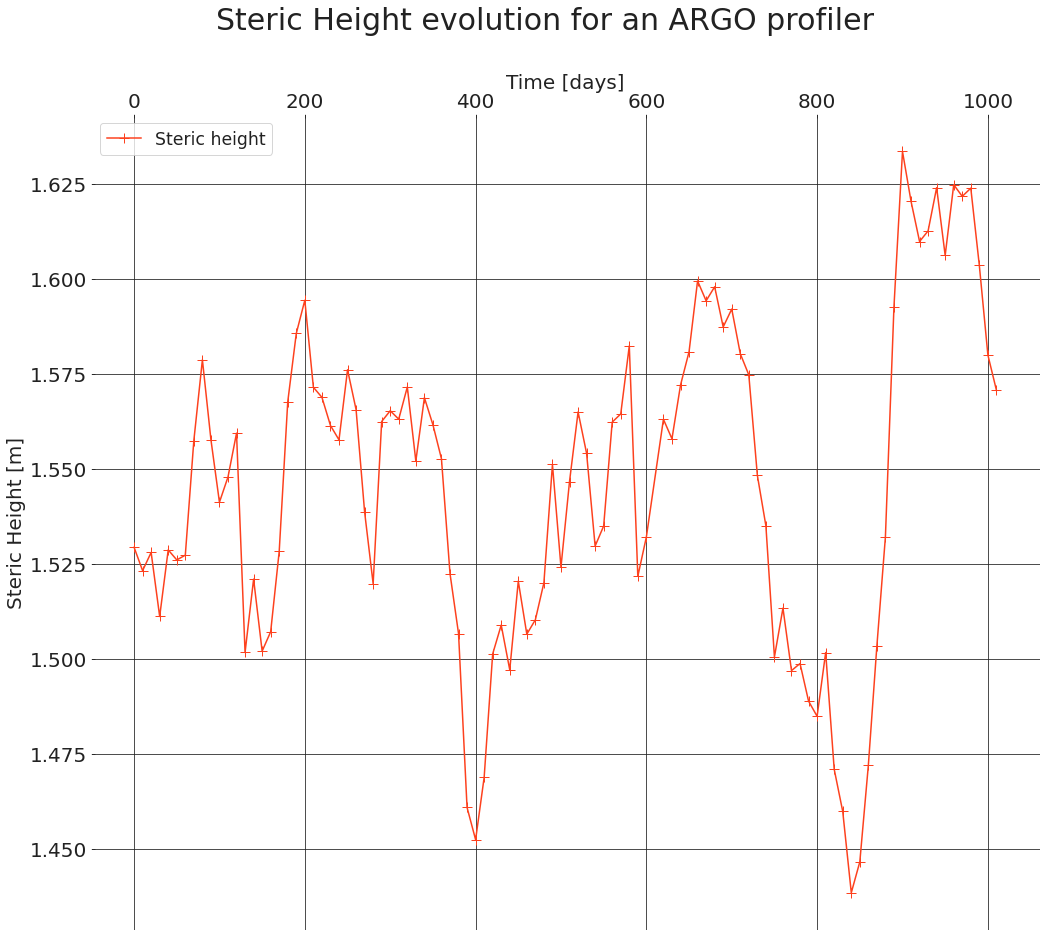

In [68]:
Steric_Plot(P,P.steric_height)

## References

Storto, 2017 pp. 709-729. ISSN 0930-7575, Steric sea level variability (1993-2010) in an ensemble of ocean reanalyses and objective analyses. Climate Dynamics, 49 (3). pp. 709-729. https://doi.org/10.1007/s00382-015-2554-9

Reiniger,  R.  F.  and  C.  K.  Ross,  1968:  A  method  of  interpolation  with  application  to 
oceanographic data. Deep‐Sea Res. 15, 185‐193.